<a href="https://colab.research.google.com/github/Aadi-RE350/SynthAI-Suite/blob/Music-Generation-Model/music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 24.6 MB/s eta 0:00:00


In [ ]:
!pip install comet_ml # Install the 'comet_ml' library using pip
!pip install mitdeeplearning # Install the 'mitdeeplearning' library using pip
import comet_ml
import tensorflow as tf
import mitdeeplearning as mdl

COMET_API_KEY = "XPfAOjuRMLwer2LtmyGUR4dX5"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mitdeeplearning: filename=mitdeeplearning-0.6.1-py3-none-any.whl size=2118512 sha256=c60bb9ba130b9501f330f74bd01bc20f73474e2533ac9d48f79feb9ff053ecd2
  Stored in directory: /root/.cache/pip/wheels/a1/67/db/909c55e80ce7fc2a8dbe1bbff0e591a69d12d11136b4cfe34c
Successfully built mitdeeplearning


In [ ]:
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
from scipy.io.wavfile import write

In [ ]:
# Download the dataset
songs = mdl.lab1.load_training_data()

# Print one of the songs to inspect it in greater detail!
example_song = songs[0]
print("\nExample song: ")
print(example_song)

Found 817 songs in text

Example song: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


In [ ]:
mdl.lab1.play_song(example_song)

In [ ]:
# Join our list of song strings into a single string containing all songs
songs_joined = "\n\n".join(songs)

# Find all unique characters in the joined string
vocab = sorted(set(songs_joined))
print("There are", len(vocab), "unique characters in the dataset")

There are 83 unique characters in the dataset


In [ ]:
### Define numerical representation of text ###

# Create a mapping from character to unique index.
# For example, to get the index of the character "d",
#   we can evaluate `char2idx["d"]`.
char2idx = {u:i for i, u in enumerate(vocab)}

# Create a mapping from indices to characters. This is
#   the inverse of char2idx and allows us to convert back
#   from unique index to the character in our vocabulary.
idx2char = np.array(vocab)

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [ ]:
def vectorize_string(string):
    return np.array([char2idx[char] for char in string])

vectorized_songs = vectorize_string(songs_joined)

In [ ]:
print ('{} ---- characters mapped to int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# check that vectorized_songs is a numpy array
assert isinstance(vectorized_songs, np.ndarray), "returned result should be a numpy array"

'X:1\nT:Alex' ---- characters mapped to int ----> [49 22 13  0 45 22 26 67 60 79]


In [ ]:
### Batch definition to create training examples ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # the length of the vectorized songs string
  n = vectorized_songs.shape[0] - 1
  # randomly choose the starting indices for the examples in the training batch
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i:i+seq_length] for i in idx]
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1:i+seq_length+1] for i in idx]

  # x_batch, y_batch provide the true inputs and targets for network training
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# Perform some simple tests to make sure your batch function is working properly!
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args):
   print("======\n[FAIL] could not pass tests")
else:
   print("======\n[PASS] passed all tests!")
### Defining the RNN Model ###

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


In [ ]:
### Defining the RNN Model ###

def LSTM(rnn_units):
    return tf.keras.layers.LSTM(
        rnn_units,
        return_sequences=True,
        recurrent_initializer='glorot_uniform',
        recurrent_activation='sigmoid',
        stateful=False  # Set to False
    )

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
        # Layer 1: Embedding layer to transform indices into dense vectors
        #   of a fixed embedding size
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=[None]),

        # Layer 2: LSTM with `rnn_units` number of units.
        LSTM(rnn_units),

        # Layer 3: Dense (fully-connected) layer that transforms the LSTM output
        #   into the vocabulary size.
        tf.keras.layers.Dense(vocab_size)
    ])

    return model

In [ ]:
# Build the model with default hyperparameters
model = build_model(len(vocab), embedding_dim=256, rnn_units=1024)

# Print the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 256)           │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 1024)          │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 83)            │          85,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Input shape:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediction shape: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Input shape:       (32, 100)  # (batch_size, sequence_length)
Prediction shape:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


In [ ]:
#Predictions from the untrained model

sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([12, 52,  4, 36,  6, 75, 27,  4, 50, 78,  7, 13, 33, 20, 15, 10, 29,
       33, 47, 44, 60, 67, 65, 31, 22, 49, 64, 11, 80, 33, 48,  9, 37, 16,
       14, 80, 75, 11, 27, 15, 50, 33, 73, 64, 20, 70, 15, 55, 80, 25, 34,
       14,  2, 76, 21, 27, 33, 33, 16, 53, 59, 16, 81,  5, 61,  8,  7, 30,
       51, 38, 79, 61, 51, 73,  4, 17,  1, 62,  8, 55, 37,  2, 55, 29, 17,
       17, 10, 39, 47,  9, 80,  5, 38, 46, 22,  2, 77, 52, 52, 62])

In [ ]:
print("Input: \n", repr("".join(idx2char[x[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

Input: 
 'B gdB|AGF G2:|!\nf|g3 bag|fed ^cde|dcB gdB|ABA ABd|!\ng3 bag|fed ^cde|dcB gdB|AGF GBd|!\ng3 bag|fed ^cd'

Next Char Predictions: 
 "0[#K(tB#Yw)1H83.DHVSeljF:Xi/yHW-L42yt/B3YHri8o3_y>I2!u9BHH4]d4z'f,)EZMxfZr#5 g,_L!_D55.NV-y'MU:!v[[g"


In [ ]:
#Training the model: loss and training operations
### Defining the loss function ###

def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)  # Updated TODO
    return loss

### Compute the loss using the true next characters from the example batch
### and the predictions from the untrained model

example_batch_loss = compute_loss(y, pred)  # Updated TODO

print("Prediction shape: ", pred.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())


Prediction shape:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.4175415


In [ ]:
### Hyperparameter setting and optimization ###

vocab_size = len(vocab)

# Model parameters:
params = dict(
  num_training_iterations = 3000,  # Increase this to train longer
  batch_size = 8,  # Experiment between 1 and 64
  seq_length = 100,  # Experiment between 50 and 500
  learning_rate = 5e-3,  # Experiment between 1e-5 and 1e-1
  embedding_dim = 256,
  rnn_units = 1024,  # Experiment between 1 and 2048
)

# Checkpoint location:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt.weights.h5")

In [ ]:
### Create a Comet experiment to track our training run ###

def create_experiment():
  # end any prior experiments
  if 'experiment' in locals():
    experiment.end()

  # initiate the comet experiment for tracking
  experiment = comet_ml.Experiment(
                  api_key=COMET_API_KEY,
                  project_name="6S191_Lab1_Part2")
  # log our hyperparameters, defined above, to the experiment
  for param, value in params.items():
    experiment.log_parameter(param, value)
  experiment.flush()

  return experiment

In [ ]:
import os

# Ensure the checkpoint directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define optimizer and training operation
def create_experiment():
    if 'experiment' in locals():
        experiment.end()
    experiment = comet_ml.Experiment(
        api_key=COMET_API_KEY,
        project_name="6S191_Lab1_Part2"
    )
    for param, value in params.items():
        experiment.log_parameter(param, value)
    experiment.flush()
    return experiment

def compute_loss(labels, logits):
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
    return loss

def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)  # Generate predictions
        loss = compute_loss(y, y_hat)  # Compute loss
    grads = tape.gradient(loss, model.trainable_variables)  # Compute gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables))  # Apply gradients
    return loss

model = build_model(len(vocab), embedding_dim=params["embedding_dim"], rnn_units=params["rnn_units"])

optimizer = tf.keras.optimizers.Adam(learning_rate=params["learning_rate"])

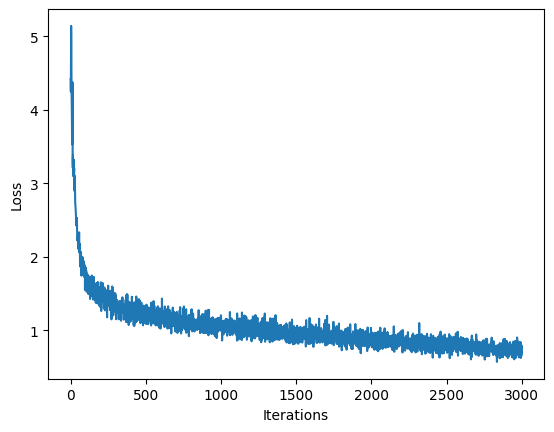

100%|██████████| 3000/3000 [3:48:51<00:00,  4.58s/it]


True

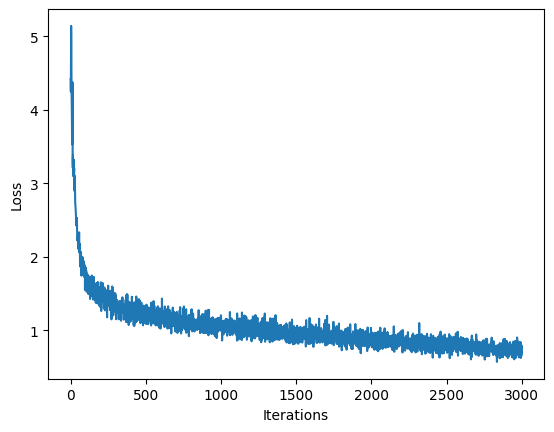

In [ ]:
##################
# Begin training!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
experiment = create_experiment()

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for iter in tqdm(range(params["num_training_iterations"])):

  # Grab a batch and propagate it through the network
  x_batch, y_batch = get_batch(vectorized_songs, params["seq_length"], params["batch_size"])
  loss = train_step(x_batch, y_batch)

  # log the loss to the Comet interface! we will be able to track it there.
  experiment.log_metric("loss", loss.numpy().mean(), step=iter)
  # Update the progress bar and also visualize within notebook
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Update the model with the changed weights!
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)

# Save the trained model and the weights
model.save_weights(checkpoint_prefix)
experiment.flush()

In [ ]:
# Save the entire model using the Keras format
model.save('my_model.keras')


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save('/content/drive/My Drive/my_model.keras')


Mounted at /content/drive


In [ ]:
# Rebuild the model using a fixed batch size of 1 for inference

def build_model(vocab_size, embedding_dim, rnn_units, batch_size=1):
    model = tf.keras.Sequential([
        # Embedding layer: input_shape should not include batch_size
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=[None]),

        # LSTM layer: configure as needed for statefulness
        tf.keras.layers.LSTM(rnn_units,
                             return_sequences=True,
                             stateful=False,  # Set to True if needed, ensuring a fixed batch size
                             recurrent_initializer='glorot_uniform'),

        # Dense layer: output layer with vocabulary size
        tf.keras.layers.Dense(vocab_size)
    ])

    return model


In [ ]:
import tensorflow as tf

# Rebuild the model with batch_size=1
def build_model(vocab_size, embedding_dim, rnn_units, batch_size=1):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=[None]),
        tf.keras.layers.LSTM(rnn_units,
                             return_sequences=True,
                             stateful=False,  # Adjust to True if needed
                             recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

# Define your hyperparameters
embedding_dim = 256
rnn_units = 1024
vocab_size = len(vocab)  # Make sure to set this according to your dataset
checkpoint_dir = './training_checkpoints'

# Rebuild the model
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

# Restore the model weights from the latest checkpoint
checkpoint_path = tf.train.latest_checkpoint(checkpoint_dir)
if checkpoint_path:
    model.load_weights(checkpoint_path)

# Build the model with the appropriate input shape for inference
model.build(tf.TensorShape([1, None]))

# Print the model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 256)           │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 1024)          │       5,246,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 83)            │          85,075 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,353,299 (20.42 MB)

 Trainable params: 5,353,299 (20.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
### Prediction of a generated song ###
def generate_text(model, start_string, generation_length=1000, vocab_to_int=None, int_to_vocab=None):
    # Evaluation step (generating text using the learned RNN model)

    # Convert the start string to numbers (vectorize)
    input_eval = [vocab_to_int[char] for char in start_string]
    input_eval = tf.expand_dims(input_eval, 0)  # Add batch dimension

    # Empty list to store the generated text
    text_generated = []

    # Here batch size == 1
    model.reset_states()
    tqdm._instances.clear()

    for i in tqdm(range(generation_length)):
        # Evaluate the inputs and generate the next character predictions
        predictions = model(input_eval)  # Feed input_eval into the model to get predictions
        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Use a multinomial distribution to sample
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

         # Pass the prediction along with the previous hidden state
         #   as the next inputs to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        # Add the predicted character to the generated text
        text_generated.append(predicted_char)

    return (start_string + ''.join(text_generated))


In [ ]:
def generate_text(model, start_string, generation_length=1000, vocab_to_int=None, int_to_vocab=None):
    # Convert start string to numbers
    input_eval = [vocab_to_int[char] for char in start_string]
    input_eval = tf.expand_dims(input_eval, 0)  # Add batch dimension

    # Empty list to store generated text
    text_generated = []

    # Here batch size == 1
    for i in tqdm(range(generation_length)):
        # Evaluate the inputs and generate the next character predictions
        predictions = model(input_eval)  # Feed input_eval into the model to get predictions
        predictions = tf.squeeze(predictions, 0)  # Remove batch dimension

        # Use a multinomial distribution to sample
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1, 0].numpy()

        # Pass the prediction along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        # Add the predicted character to the generated text
        predicted_char = int_to_vocab[predicted_id]
        text_generated.append(predicted_char)

    return (start_string + ''.join(text_generated))


# Define vocab_to_int and int_to_vocab
vocab_to_int = char2idx
int_to_vocab = idx2char

# Generate the ABC format text of length 1000 using the model
generated_text = generate_text(model, start_string="X", generation_length=1000, vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab)

print(generated_text)


100%|██████████| 1000/1000 [00:22<00:00, 45.28it/s]

Xc)]^KjroovM'K03P_mzVgf4M
lki04vhnVp^,<Iy1T7glQ9<L35gXb-hrXSXzqu0VL[K>K1XX_X^=fwF)J3(qFJk5#M7JKj=qYBH
wGj<NHkxXa91!L53OZ4N/rLo!(8Hm
g
KU23Jp60vk7(v.x=G|2h#Rqq:kU'GjZoJjqM-(:3CQl,0dJCgzm"vRtaw2Gt_t<i cpOi^JLS S,e,IUIK^K=rC^qz2==]a><<lJp6xf#cG2!(Q 2yB
INf/8uyG!S-:o=ZYQ0zTwOU,ZW
Is^59LJs|8HywA'!itqdqVjb(zF2opWVIaJxQX7KlpeAyZ^,s|RsFkWPhNcXN!eSSGHz2kSl(w V^gtCBA)E(^U0#pvHn>MJCt7bRWn9ThP)ZbvPWkl.tvq=|_VGgo26Q3K<T>'Jv>l!AVXnvro_19B8 Vlhk5hLZNyDwmg^z-s/n=hJ"2YUO((6fw/3IC6/=E7!4NR,VhmHgmKqApuJ7,ZLz2Z#) 1
!gF'<A',4 sSJr
tGnxLBmX
/r0
JX<MOE8/EoE-87AQbNWN
es57JOXj!kx64p6=S/V'k.AhihaVm9yK^4Wf7sS'F25VtQg#lE.d/el.j(7UGi,Pk(08|B(a(Q_[0FzepZuh>Z4 6IR3qRA"0ZWzf^oDTC>u^]#4MF#9CpKVRtoT6rC.waZkSD-dZAU)[uIrc>NUh^|!jsP0JkbZ-3lhorhL]LAC1J!O0MK-R
o.-YJtSe>A>kk)OG>m##8U1aXU459/E#z3IX:NeS"kORpwAvBic7pFRU,dx,y0/(Ys7POHJMtHO1[[ov|>Q#>mc_2MoO7M9G"lAAGAcf#Eg.7D=b
8O7Ca)t,
G)vmoyGE(9>|t Bokkm]6BjIZF7c40)iQH_O979l)VLlN4J8vs,pF:W^mkxR/:H.1y^dpvgko4cJ28"Vf1|4ymSFJ0qG
bJlyoyPzOx()syo#G(zu30p>Q7h0q2-]29_R7c13^]ctTl/y[JG2r

In [ ]:
import mitdeeplearning as mdl
import mitdeeplearning as mdl
import numpy as np
from scipy.io.wavfile import write
from IPython import display as ipythondisplay

# Ensure that the mdl.lab1 module has been correctly imported
# and that the functions `extract_song_snippet` and `play_song` are available.

if hasattr(mdl.lab1, 'extract_song_snippet') and hasattr(mdl.lab1, 'play_song'):
    # Extract song snippets from generated text
    generated_songs = mdl.lab1.extract_song_snippet(generated_text)

    for i, song in enumerate(generated_songs):
        # Synthesize the waveform from a song
        waveform = mdl.lab1.play_song(song)

        # If it's a valid song (correct syntax), let's play it!
        if waveform:
            print("Generated song", i)
            ipythondisplay.display(waveform)

            numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
            wav_file_path = f"output_{i}.wav"
            write(wav_file_path, 88200, numeric_data)

            # Save your song to the Comet interface -- you can access it there
            experiment.log_asset(wav_file_path)
else:
    print("The required functions `extract_song_snippet` or `play_song` are not available in `mdl.lab1`.")


ModuleNotFoundError: No module named 'mitdeeplearning'

In [ ]:
# when done, end the comet experiment
experiment.end()

In [ ]:
# Save the entire model using the Keras format
model.save('my_model.keras')


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Save the model to Google Drive
model.save('/content/drive/My Drive/my_model.keras')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save the model to Google Drive
model.save('/content/drive/My Drive/my_model.keras')


In [ ]:
from diffusers import MusicLDMPipeline
import torch
import scipy

repo_id = "ucsd-reach/musicldm"
pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

prompt = "Techno music with a strong, upbeat tempo and high melodic riffs"
audio = pipe(prompt, num_inference_steps=10, audio_length_in_s=5.0).audios[0]

# save the audio sample as a .wav file
scipy.io.wavfile.write("techno.wav", rate=16000, data=audio)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/521 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/494 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/776M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

vocoder/config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/740M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/222M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
prompt = "genrate bass music with high tone and note"
audio = pipe(prompt, num_inference_steps=10, audio_length_in_s=5.0).audios[0]

# save the audio sample as a .wav file
scipy.io.wavfile.write("basssss.wav", rate=16000, data=audio)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
prompt = "genrate lofi music with soft and melody tone"
audio = pipe(prompt, num_inference_steps=10, audio_length_in_s=5.0).audios[0]

# save the audio sample as a .wav file
scipy.io.wavfile.write("lofi.wav", rate=16000, data=audio)

  0%|          | 0/10 [00:00<?, ?it/s]